# Pylops - Non-stationary convolution

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve2D`` and ``NonStationaryConvolve3D`` operators to perform non-stationary convolution with on-the-fly interpolation between the available filters (which are provided at a coarser grid then the grid of computation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit, cuda
from time import perf_counter

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from visual import explode_volume

In [2]:
def time_cuda(Op, x, n=10, unit='s'):
    cuda.synchronize()
    timing = np.empty(n)
    for i in range(timing.size):
        tic = perf_counter()
        y = Op @ x
        cuda.synchronize()
        toc = perf_counter()
        timing[i] = toc - tic
    if unit == 'ms':
        timing *= 1e3  # convert to ms
    print(f"Elapsed time: {timing.mean():.2f} ± {timing.std():.2f} {unit}")      
    return timing.mean()


def time_numba(Op, x, n=10, unit='s'):
    timing = np.empty(n)
    for i in range(timing.size):
        tic = perf_counter()
        y = Op @ x
        toc = perf_counter()
        timing[i] = toc - tic
    if unit == 'ms':
        timing *= 1e3  # convert to ms
    print(f"Elapsed time: {timing.mean():.2f} ± {timing.std():.2f} {unit}")      
    return timing.mean()

## 2D


0.00029902418355556447

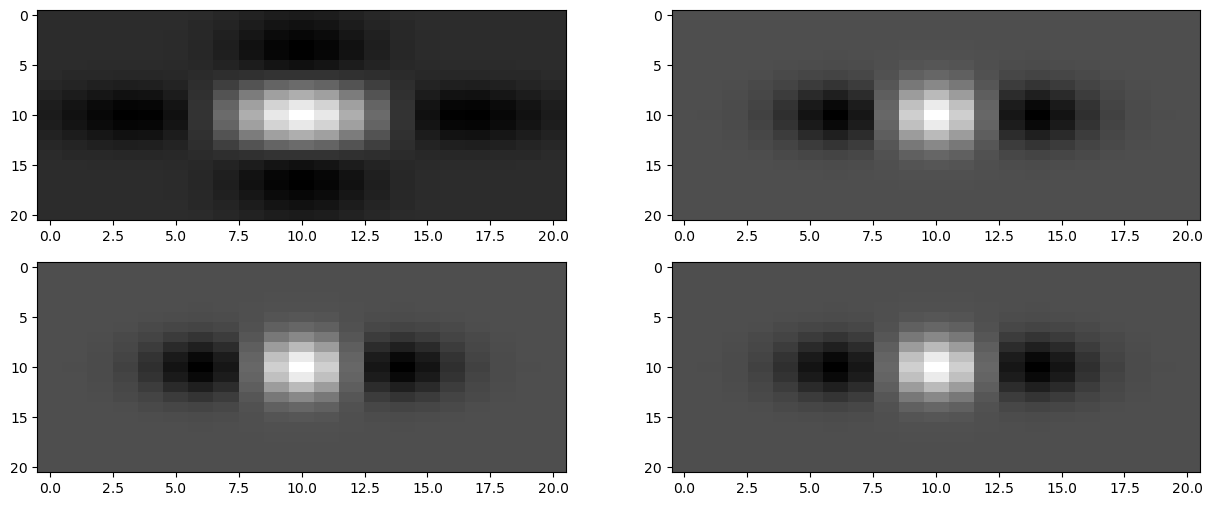

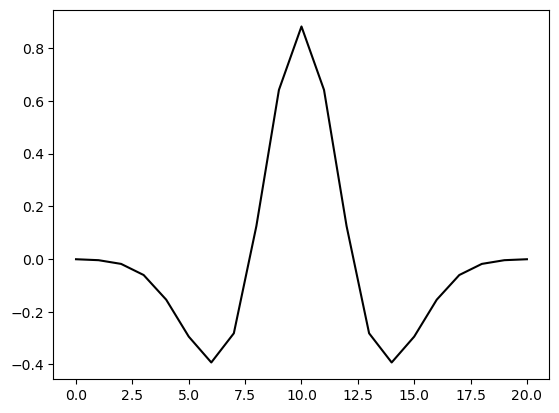

In [3]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

nx, nz = 601, 501

wav1a, _, wav1c = ricker(t[:11], f0=15)
wav1b = ricker(t[:11], f0=25)[0]
wav2 = sp.signal.windows.gaussian(21, 2.)

wav11 = np.outer(wav1a, wav2[np.newaxis]).T
wav11 = wav11 + wav11.T
wav12 = np.outer(wav1b, wav2[np.newaxis]).T
wav21 = np.outer(wav1b, wav2[np.newaxis]).T
wav22 = np.outer(wav1b, wav2[np.newaxis]).T
wavsize = wav11.shape

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs[0,0].imshow(wav11, 'gray')
axs[0,0].axis('tight')
axs[0,1].imshow(wav12, 'gray')
axs[0,1].axis('tight')
axs[1,0].imshow(wav21, 'gray')
axs[1,0].axis('tight')
axs[1,1].imshow(wav22, 'gray')
axs[1,1].axis('tight');

plt.figure()
plt.plot(wav12[11], 'k')

np.sum(wav12[11])

In [4]:
hs = np.zeros((2, 2, *wavsize))
hs[0, 0] = wav12
hs[0, 1] = wav12
hs[1, 0] = wav12
hs[1, 1] = wav12

Copnp = NonStationaryConvolve2D(hs=hs, ihx=(21, nx-21), ihz=(21, nz-21), dims=(nx, nz), engine="numpy")
Cop = NonStationaryConvolve2D(hs=hs, ihx=(21, nx-21), ihz=(21, nz-21), dims=(nx, nz), engine="numba")
Copcp = NonStationaryConvolve2D(hs=cp.asarray(hs), ihx=(21, nx-21), ihz=(21, nz-21), dims=(nx, nz), engine="cuda")

dottest(Copnp, verb=True), dottest(Cop, verb=True), dottest(Copcp, verb=True, backend='cupy');

Dot test passed, v^H(Opu)=455.5060173887107 - u^H(Op^Hv)=455.50601738870773
Dot test passed, v^H(Opu)=1185.3224785539605 - u^H(Op^Hv)=1185.3224785539574
Dot test passed, v^H(Opu)=-2213.683179955487 - u^H(Op^Hv)=-2213.6831799554875


In [5]:
# Forward
x = np.zeros((nx, nz))
x[:, 201] = 1.
x[:, 401] = -1.
xcp = cp.asarray(x)

Cop * x #dry-run
Copcp * xcp #dry-run
%timeit -n1 -r1 Copnp * x
%timeit -n1 -r1 Cop * x
%timeit -n1 -r1 Copcp * xcp
time_cuda(Copcp, xcp, unit='ms')

4.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
103 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time: 5.52 ± 0.46 ms


5.520780943334103

In [6]:
# Adjoint
Cop.H * x #dry-run
Copcp.H * xcp #dry-run
%timeit -n1 -r1 Copnp.H * x
%timeit -n1 -r1 Cop.H * x
%timeit -n1 -r1 Copcp.H * xcp
time_cuda(Copcp.H, xcp, unit='ms')

4.73 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
108 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time: 9.00 ± 0.67 ms


8.998431079089642

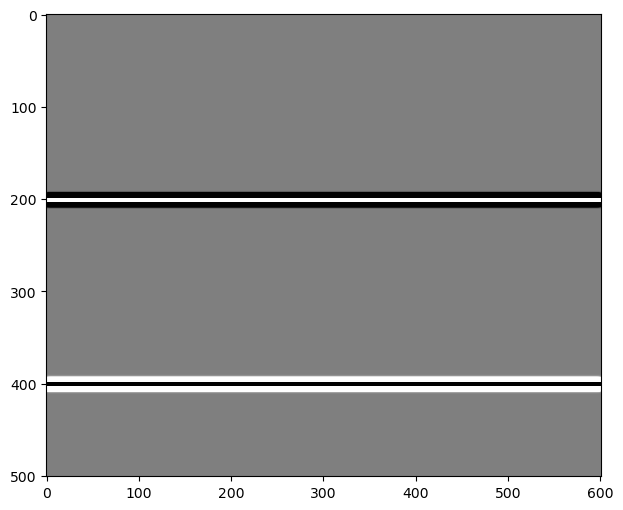

In [7]:
y = Cop * x

plt.figure(figsize=(15, 6))
plt.imshow(y.T, 'gray', vmin=-0.1, vmax=0.1);

## 3D


In [8]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

ny, nx, nz = 101, 101, 101

wav1a, _, wav1c = ricker(t[:11], f0=12)
wav1b = ricker(t[:11], f0=10)[0]
wav2 = sp.signal.windows.gaussian(21, 2.)

wav11 = np.outer(wav1b, np.outer(wav1a, wav2[np.newaxis]).T).reshape(21, 21 ,21)
wav11 = wav11.transpose(1, 0, 2)
wavsize = wav11.shape
wavsize

(21, 21, 21)

1.4344080026383776

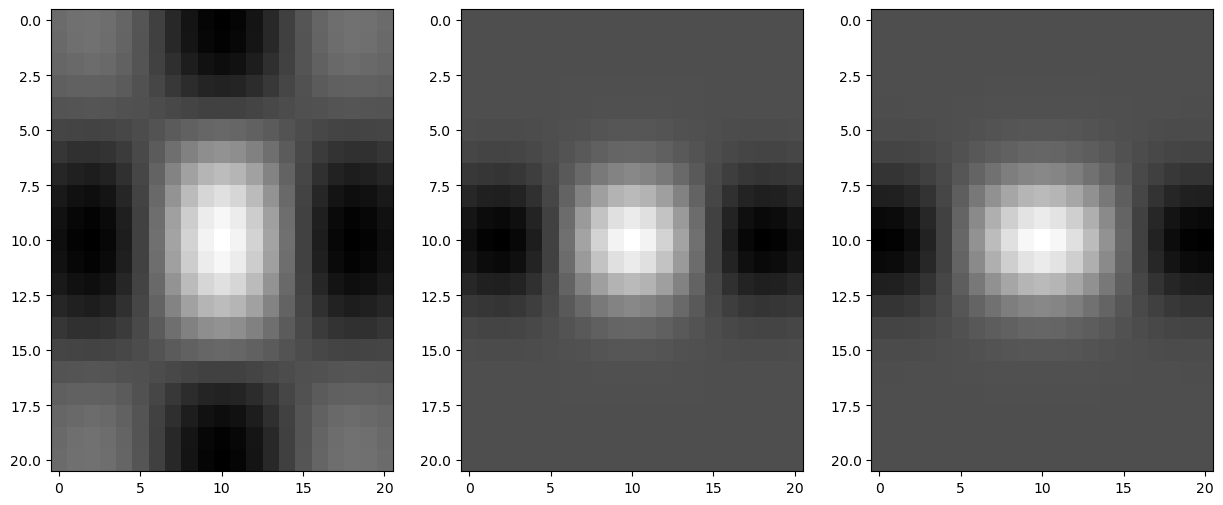

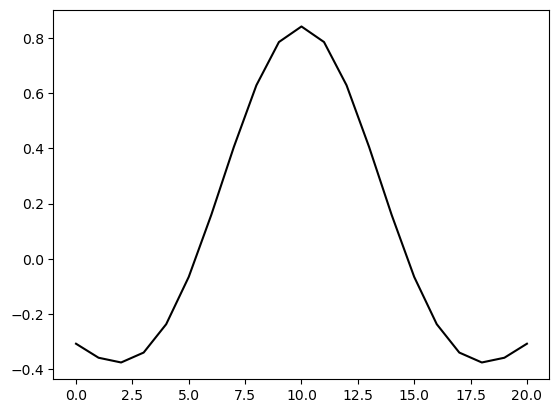

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(wav11[11], 'gray')
axs[0].axis('tight')
axs[1].imshow(wav11[:, 11], 'gray')
axs[1].axis('tight')
axs[2].imshow(wav11[:, :, 11], 'gray')
axs[2].axis('tight');

plt.figure()
plt.plot(wav11[11, 11], 'k')
np.sum(wav11[11, 11])

In [10]:
hs = np.zeros((2, 2, 2, *wavsize))

for iy in range(2):
    for ix in range(2):
        for iz in range(2):
            hs[iy, ix, iz] = wav11

Copnp = NonStationaryConvolve3D(hs=hs, ihy=(21, 81), ihx=(21, 81), 
                                ihz=(21, 81), dims=(ny, nx, nz), engine="numpy")
Cop = NonStationaryConvolve3D(hs=hs, ihy=(21, 81), ihx=(21, 81), 
                                ihz=(21, 81), dims=(ny, nx, nz), engine="numba")
Copcp = NonStationaryConvolve3D(hs=cp.asarray(hs), ihy=(21, 81), ihx=(21, 81), 
                                ihz=(21, 81), dims=(ny, nx, nz), 
                                num_threads_per_blocks=(8, 8, 16), engine="cuda", 
                                dtype=np.float32)

#dottest(Copnp, verb=True), 
#dottest(Cop, verb=True),
dottest(Copcp, verb=True, backend='cupy', atol=1e-2);

Dot test passed, v^H(Opu)=15606.96875 - u^H(Op^Hv)=15606.955078125


In [11]:
# Forward
x = np.zeros((ny, nx, nz))
x[:, :, 31] = 1.
x[:, :, 61] = -1.
xcp = cp.asarray(x)

y = Cop * x #dry-run
ycp = Copcp * xcp #dry-run
#%timeit -n1 -r1 Copnp * x
%timeit -n1 -r1 Cop * x
%timeit -n1 -r1 Copcp * xcp
time_cuda(Copcp, xcp, unit='s')

4.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.82 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time: 0.96 ± 0.01 s


0.9573216391261667

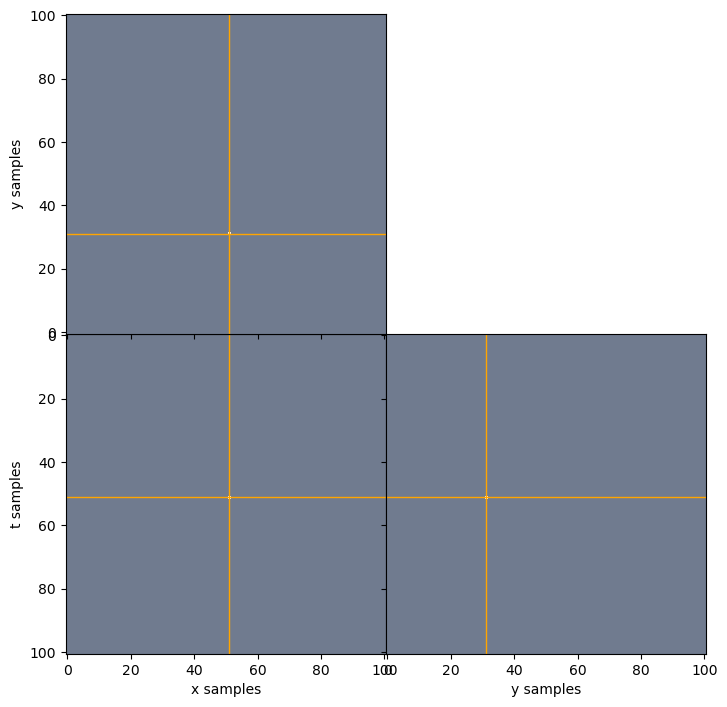

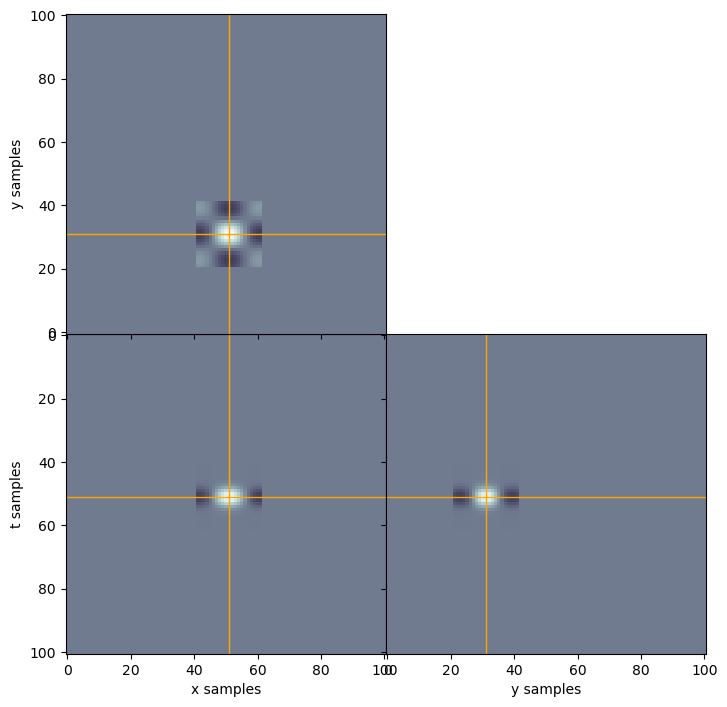

In [12]:
x = np.zeros((ny, nx, nz))
x[51, 51, 31] = 1.
xcp = cp.asarray(x)
ycp = Copcp * xcp #dry-run
y = cp.asnumpy(ycp)

explode_volume(x, t=51, x=51, y=31, clipval=[-1,1])
explode_volume(y, t=51, x=51, y=31, clipval=[-1,1])

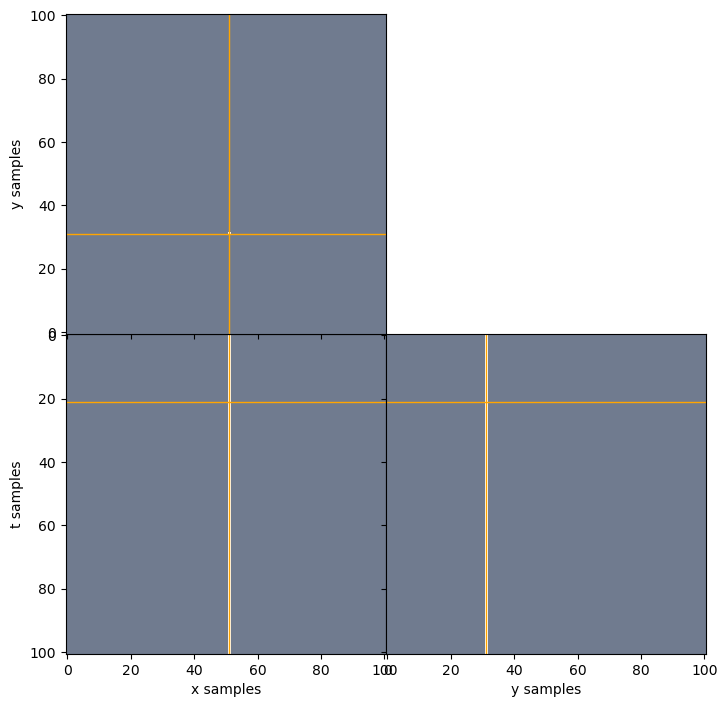

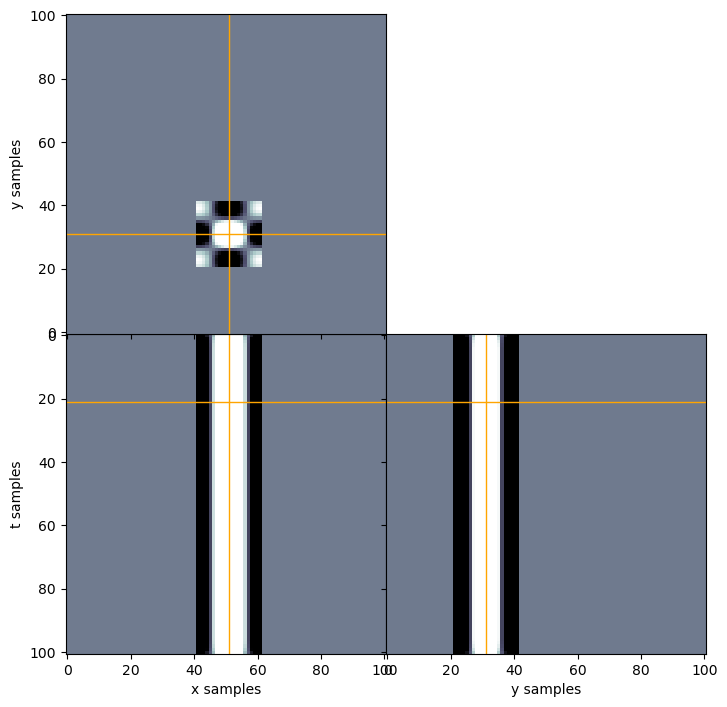

In [13]:
x = np.zeros((ny, nx, nz))
x[:, 51, 31] = 1.
xcp = cp.asarray(x)
ycp = Copcp * xcp #dry-run
y = cp.asnumpy(ycp)

explode_volume(x, t=21, x=51, y=31, clipval=[-1,1])
explode_volume(y, t=21, x=51, y=31, clipval=[-1,1])

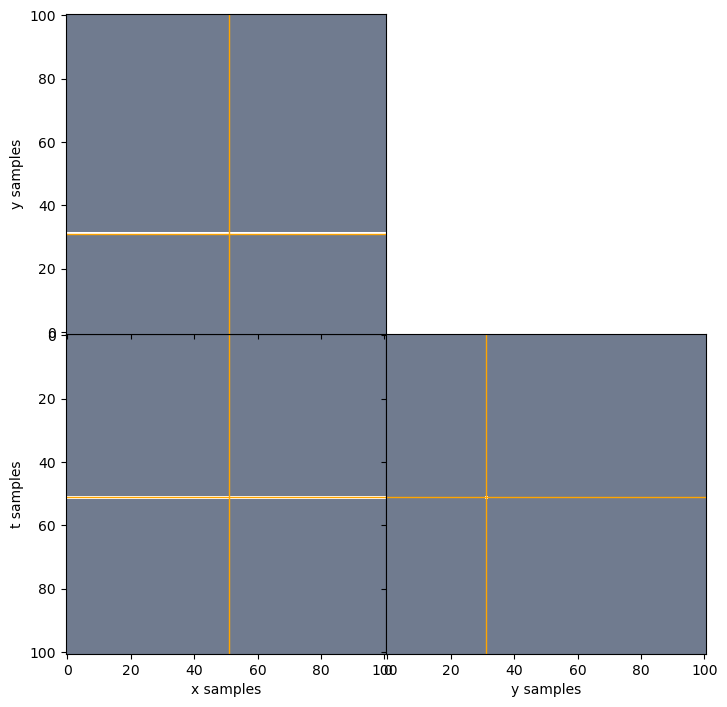

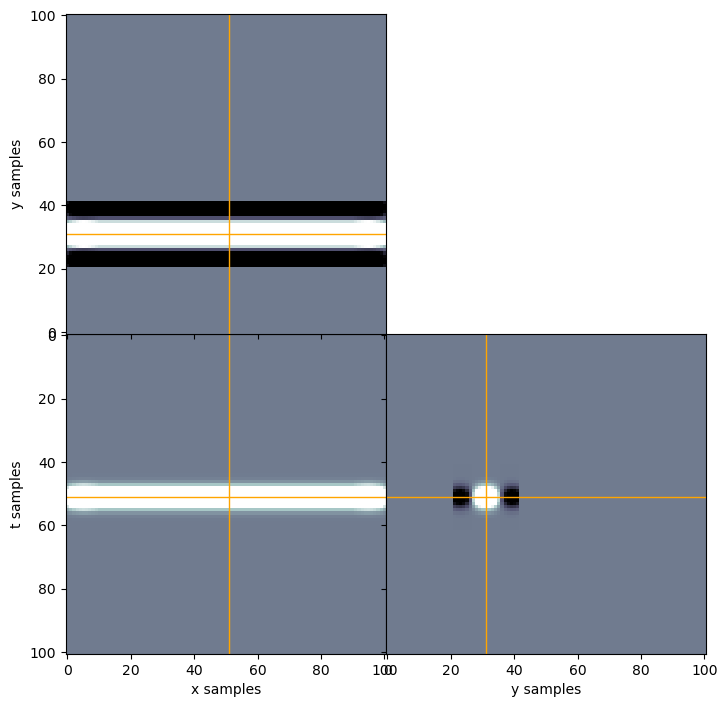

In [14]:
x = np.zeros((ny, nx, nz))
x[51, :, 31] = 1.
xcp = cp.asarray(x)
ycp = Copcp * xcp #dry-run
y = cp.asnumpy(ycp)

explode_volume(x, t=51, x=51, y=31, clipval=[-1,1])
explode_volume(y, t=51, x=51, y=31, clipval=[-1,1])

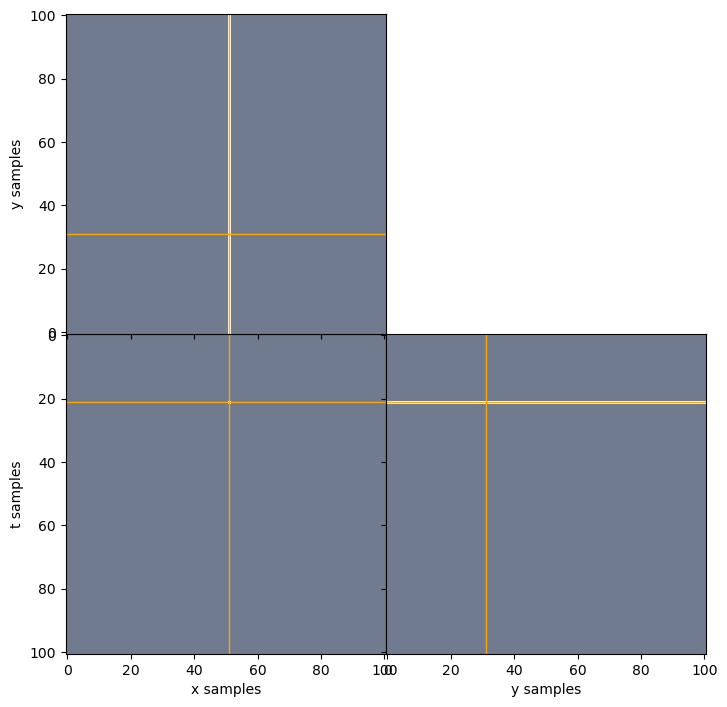

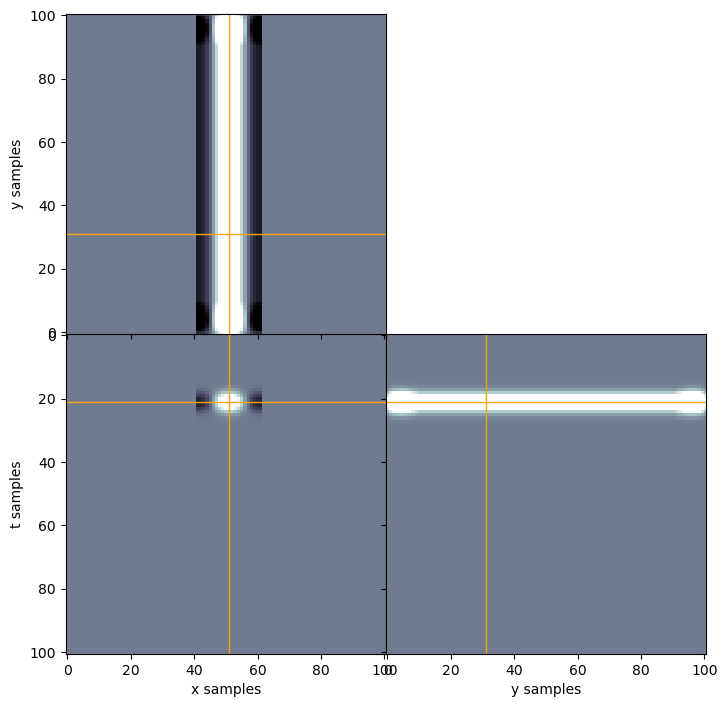

In [15]:
x = np.zeros((ny, nx, nz))
x[21, 51] = 1.
xcp = cp.asarray(x)
ycp = Copcp * xcp #dry-run
y = cp.asnumpy(ycp)

explode_volume(x, t=21, x=51, y=31, clipval=[-1,1])
explode_volume(y, t=21, x=51, y=31, clipval=[-1,1])

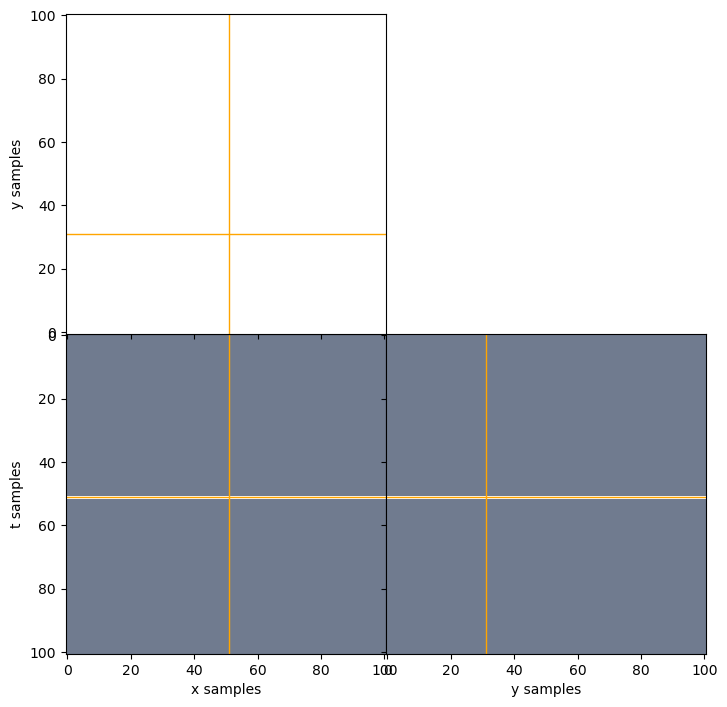

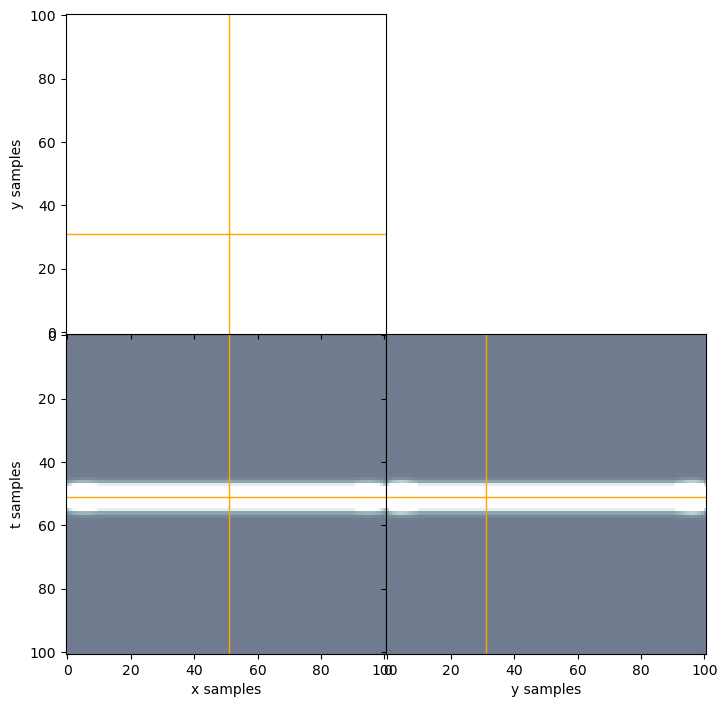

In [16]:
x = np.zeros((ny, nx, nz))
x[51] = 1.
xcp = cp.asarray(x)
ycp = Copcp * xcp #dry-run
y = cp.asnumpy(ycp)

explode_volume(x, t=51, x=51, y=31, clipval=[-1,1])
explode_volume(y, t=51, x=51, y=31, clipval=[-1,1])

In [17]:
nmodels = [50, 100, 150, 200, 300, 400]

tsnumba = []
tscuda = []
for nmodel in nmodels:
    ny, nx, nz = nmodel, nmodel, nmodel-5
    # PSF Model
    psfin = (10, 10, 7)
    psfend = (-10, -10, -7)
    psfj = (10, 10, 10)
    psfsize = (7, 7, 7)

    # PSF grid
    psfy = np.arange(psfin[0], ny+psfend[0], psfj[0])
    psfx = np.arange(psfin[1], nx+psfend[1], psfj[1])
    psfz = np.arange(psfin[2], nz+psfend[2], psfj[2])

    psfs = np.ones((len(psfy), len(psfx), len(psfz), *psfsize))

    Cop = NonStationaryConvolve3D(dims=(ny, nx, nz), hs=psfs, ihy=psfy, ihx=psfx, ihz=psfz, engine="numba")
    Cop_cuda = NonStationaryConvolve3D(dims=(ny, nx, nz), hs=psfs, ihy=psfy, ihx=psfx, ihz=psfz, engine="cuda")

    x = np.ones(Cop.dimsd)
    xcp = cp.asarray(x)
    
    tsnumba.append(time_numba(Cop, x, n=3, unit='ms'))
    tscuda.append(time_cuda(Cop_cuda, xcp, n=3, unit='ms'))

Elapsed time: 1123.35 ± 1535.46 ms


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 165.75 ± 219.08 ms
Elapsed time: 1367.75 ± 1511.13 ms


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 92.72 ± 5.42 ms
Elapsed time: 2144.95 ± 1482.88 ms


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 304.63 ± 10.18 ms
Elapsed time: 3872.77 ± 1780.64 ms


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 711.95 ± 10.53 ms
Elapsed time: 9792.76 ± 1049.48 ms


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 2403.87 ± 22.40 ms
Elapsed time: 24424.89 ± 1745.27 ms


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Elapsed time: 5681.18 ± 23.56 ms


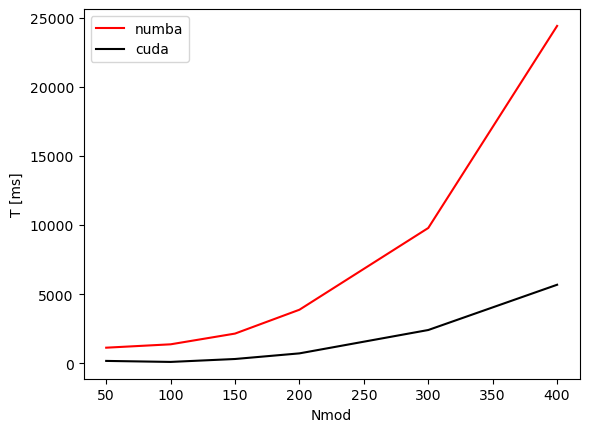

In [18]:
plt.figure()
plt.plot(nmodels, tsnumba, 'r', label='numba')
plt.plot(nmodels, tscuda, 'k', label='cuda')
plt.xlabel('Nmod')
plt.ylabel('T [ms]')
plt.legend();